In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

sns.set(style="whitegrid")

In [13]:
## 1. LOAD DATA
df = pd.read_csv("../data/water_quality_cleaned.csv")
print("Ukuran dataset:", df.shape)
display(df.head())
print("\nKolom dataset:", df.columns.tolist())


Ukuran dataset: (3276, 30)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,...,Qi_Conductivity,WiQi_Conductivity,Qi_Organic_carbon,WiQi_Organic_carbon,Qi_Trihalomethanes,WiQi_Trihalomethanes,Qi_Turbidity,WiQi_Turbidity,WQI,WQI_category
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,...,100.000000,10.000000,100.0,10.0,100.000000,10.000000,59.262708,5.333644,79.606391,Very Poor
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0,...,100.000000,10.000000,100.0,10.0,70.411345,7.041135,90.013125,8.101181,75.314724,Very Poor
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0,...,100.000000,10.000000,100.0,10.0,83.025116,8.302512,61.118675,5.500681,86.294241,Very Poor
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,...,90.816629,9.081663,100.0,10.0,100.000000,10.000000,92.575411,8.331787,92.375185,Very Poor
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,...,99.602703,9.960270,100.0,10.0,39.997491,3.999749,81.501509,7.335136,84.539184,Very Poor



Kolom dataset: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability', 'Qi_ph', 'WiQi_ph', 'Qi_Hardness', 'WiQi_Hardness', 'Qi_Solids', 'WiQi_Solids', 'Qi_Chloramines', 'WiQi_Chloramines', 'Qi_Sulfate', 'WiQi_Sulfate', 'Qi_Conductivity', 'WiQi_Conductivity', 'Qi_Organic_carbon', 'WiQi_Organic_carbon', 'Qi_Trihalomethanes', 'WiQi_Trihalomethanes', 'Qi_Turbidity', 'WiQi_Turbidity', 'WQI', 'WQI_category']


In [15]:
## 2. FEATURES & TARGET
# Di notebook ini kita memprediksi **WQI** (regresi).
# Fitur: ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity

features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
            'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
target = 'WQI'

# safety check: pastikan fitur ada di df
missing_feats = [c for c in features + [target] if c not in df.columns]
if missing_feats:
    raise ValueError(f"Kolom hilang di dataset: {missing_feats}")

X = df[features].copy()
y = df[target].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3276, 9)
y shape: (3276,)


In [17]:
## 3. TRAIN-TEST SPLIT
# Split data 80/20 dengan random_state untuk reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2620, 9) Test: (656, 9)


In [42]:
## 4. PIPELINE DEFINITION
# Kita gunakan pipeline: scaling (StandardScaler) + estimator
def evaluate_model(model, X_tr, X_te, y_tr, y_te, cv=5):
    """Fit model, return dict dengan metrik (train & test) dan cross-val R2."""
    # Fit
    model.fit(X_tr, y_tr)
    # Predict
    y_pred = model.predict(X_te)
    y_train_pred = model.predict(X_tr)
    # Metrics
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2_train = r2_score(y_tr, y_train_pred)
    # Cross-val on training set
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='r2')
    result = {
        "r2_test": r2,
        "mae_test": mae,
        "rmse_test": rmse,
        "r2_train": r2_train,
        "cv_r2_mean": cv_scores.mean(),
        "cv_r2_std": cv_scores.std(),
        "y_pred": y_pred
    }
    return result


Linear Regression results (test):
R2: 0.7323, MAE: 2.4502, RMSE: 2.9281
Train R2: 0.7367, CV R2 mean: 0.7329 ± 0.0274


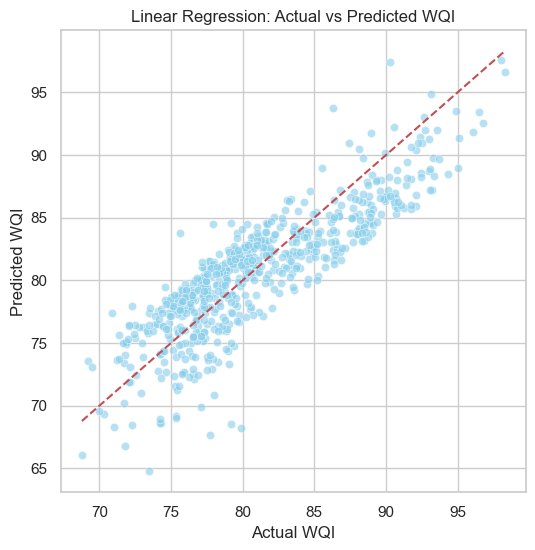

In [50]:
## 5. BASELINE MODEL: Linear Regression
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
res_lr = evaluate_model(pipe_lr, X_train, X_test, y_train, y_test, cv=5)
print("Linear Regression results (test):")
print(f"R2: {res_lr['r2_test']:.4f}, MAE: {res_lr['mae_test']:.4f}, RMSE: {res_lr['rmse_test']:.4f}")
print(f"Train R2: {res_lr['r2_train']:.4f}, CV R2 mean: {res_lr['cv_r2_mean']:.4f} ± {res_lr['cv_r2_std']:.4f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=res_lr["y_pred"], color='skyblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title("Linear Regression: Actual vs Predicted WQI")
plt.show()

Best params (Decision Tree): {'dt__max_depth': None, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10}
Decision Tree (test) R2: 0.8922, MAE: 1.3760, RMSE: 1.8578


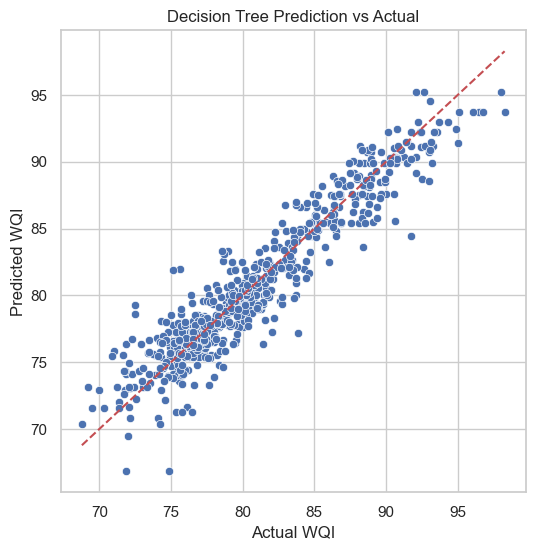

In [48]:
## 6. Decision Tree Regressor (default) + GridSearchCV tuning
pipe_dt = Pipeline([("scaler", StandardScaler()), ("dt", DecisionTreeRegressor(random_state=42))])

# Quick grid for Decision Tree
param_grid_dt = {
    "dt__max_depth": [None, 3, 5, 8, 12],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 4, 8]
}

grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5, scoring='r2', n_jobs=-1, verbose=0)
grid_dt.fit(X_train, y_train)

print("Best params (Decision Tree):", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_
res_dt = evaluate_model(best_dt, X_train, X_test, y_train, y_test, cv=5)
print(f"Decision Tree (test) R2: {res_dt['r2_test']:.4f}, MAE: {res_dt['mae_test']:.4f}, RMSE: {res_dt['rmse_test']:.4f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=res_dt['y_pred'])
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title("Decision Tree Prediction vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Best params (Random Forest): {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Random Forest (test) R2: 0.9586, MAE: 0.8021, RMSE: 1.1522


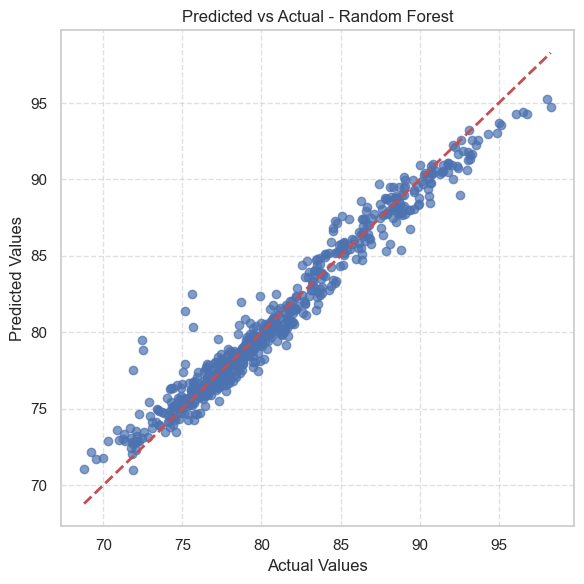

In [53]:
## 7. Random Forest Regressor + GridSearchCV tuning
pipe_rf = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))])

param_grid_rf = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=0)
grid_rf.fit(X_train, y_train)

print("Best params (Random Forest):", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
res_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test, cv=5)
print(f"Random Forest (test) R2: {res_rf['r2_test']:.4f}, MAE: {res_rf['mae_test']:.4f}, RMSE: {res_rf['rmse_test']:.4f}")

# === 2️⃣ Predicted vs Actual ===
y_pred = best_rf.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicted vs Actual - Random Forest")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Best params (SVR): {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
SVR (test) R2: 0.9109, MAE: 1.2164, RMSE: 1.6890


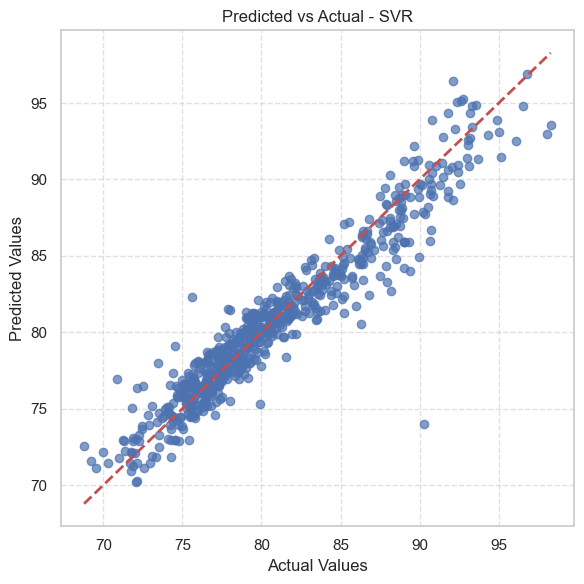

In [55]:
## 8. Support Vector Regressor (SVR) + GridSearchCV tuning
# SVR sensitif ke scaling (kita punya scaler di pipeline). Tuning kernel & C & gamma.
pipe_svr = Pipeline([("scaler", StandardScaler()), ("svr", SVR())])

param_grid_svr = {
    "svr__kernel": ["rbf", "linear"],
    "svr__C": [0.1, 1, 10, 50],
    "svr__gamma": ["scale", "auto"]
}

grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5, scoring='r2', n_jobs=-1, verbose=0)
grid_svr.fit(X_train, y_train)

print("Best params (SVR):", grid_svr.best_params_)
best_svr = grid_svr.best_estimator_
res_svr = evaluate_model(best_svr, X_train, X_test, y_train, y_test, cv=5)
print(f"SVR (test) R2: {res_svr['r2_test']:.4f}, MAE: {res_svr['mae_test']:.4f}, RMSE: {res_svr['rmse_test']:.4f}")

# === 1️⃣ Predicted vs Actual ===
y_pred = best_svr.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicted vs Actual - SVR")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
## 9. KUMPULKAN SEMUA HASIL
results_summary = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "SVR"],
    "R2_test": [res_lr["r2_test"], res_dt["r2_test"], res_rf["r2_test"], res_svr["r2_test"]],
    "MAE_test": [res_lr["mae_test"], res_dt["mae_test"], res_rf["mae_test"], res_svr["mae_test"]],
    "RMSE_test": [res_lr["rmse_test"], res_dt["rmse_test"], res_rf["rmse_test"], res_svr["rmse_test"]],
    "R2_train": [res_lr["r2_train"], res_dt["r2_train"], res_rf["r2_train"], res_svr["r2_train"]],
    "CV_R2_mean": [res_lr["cv_r2_mean"], res_dt["cv_r2_mean"], res_rf["cv_r2_mean"], res_svr["cv_r2_mean"]],
    "CV_R2_std": [res_lr["cv_r2_std"], res_dt["cv_r2_std"], res_rf["cv_r2_std"], res_svr["cv_r2_std"]]
})

results_summary = results_summary.sort_values(by="R2_test", ascending=False).reset_index(drop=True)
display(results_summary)
results_summary.to_csv("modeling_results_summary.csv", index=False)
print("Saved modeling_results_summary.csv")


,Model,R2_test,MAE_test,RMSE_test,R2_train,CV_R2_mean,CV_R2_std
0,Random Forest,0.958552,0.802104,1.152174,0.994736,0.958761,0.006808
1,SVR,0.910931,1.216404,1.688995,0.972130,0.915715,0.006109
2,Decision Tree,0.892236,1.375976,1.857806,0.978904,0.901153,0.003333
3,Linear Regression,0.732311,2.450219,2.928054,0.736683,0.732876,0.027423


Saved modeling_results_summary.csv


Model terbaik (by R2_test): Random Forest


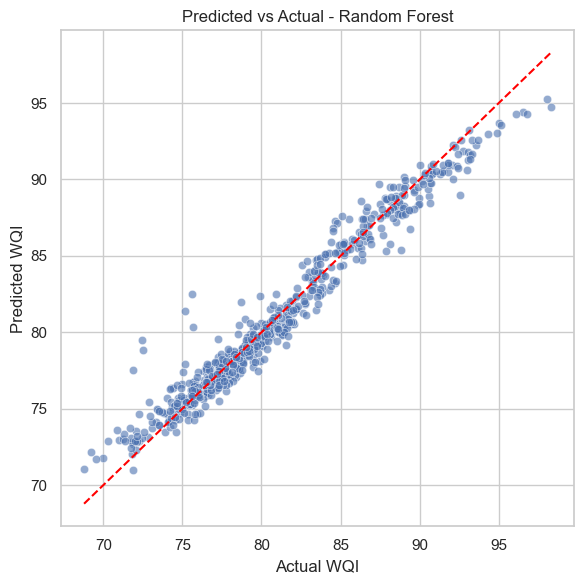

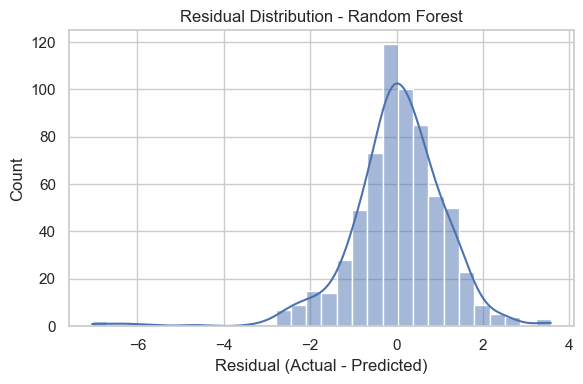

In [33]:
## 10. VISUALISASI: Prediksi vs Actual (untuk model terbaik)
# Pilih model terbaik berdasarkan R2_test
best_model_name = results_summary.loc[0, "Model"]
print("Model terbaik (by R2_test):", best_model_name)

model_map = {
    "Linear Regression": pipe_lr,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "SVR": best_svr
}
best_model = model_map[best_model_name]

# Get predictions for test set
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title(f"Predicted vs Actual - {best_model_name}")
plt.tight_layout()
plt.show()

# Residual distribution
residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f"Residual Distribution - {best_model_name}")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


,feature,importance
0,ph,0.732508
7,Trihalomethanes,0.107457
8,Turbidity,0.063547
1,Hardness,0.037810
5,Conductivity,0.025603
4,Sulfate,0.018245
3,Chloramines,0.007582
2,Solids,0.003957
6,Organic_carbon,0.003291


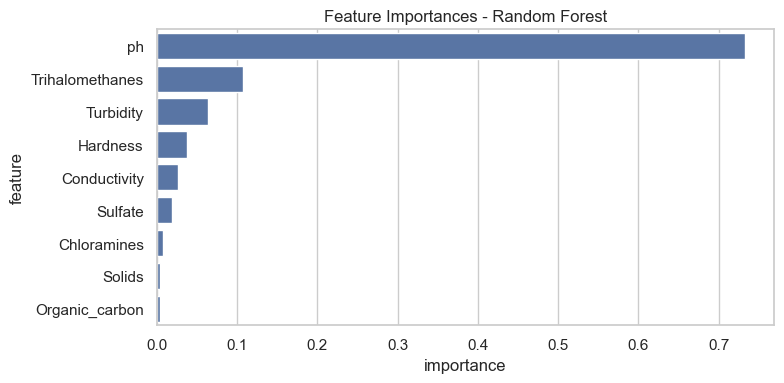

In [35]:
## 11. FEATURE IMPORTANCE (untuk tree-based models)
# Random Forest feature importance (if available)
if hasattr(best_rf.named_steps['rf'], "feature_importances_"):
    importances = best_rf.named_steps['rf'].feature_importances_
    fi = pd.DataFrame({"feature": features, "importance": importances}).sort_values("importance", ascending=False)
    display(fi)
    plt.figure(figsize=(8,4))
    sns.barplot(x="importance", y="feature", data=fi)
    plt.title("Feature Importances - Random Forest")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importances available for Random Forest.")


In [37]:
## 12. SIMPAN MODEL & SCALER (untuk deployment/inference)
# Save the best estimator and scaler (pipelines already include scaler)
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
print(f"Saved best model: best_model_{best_model_name.replace(' ', '_')}.pkl")

# Save all models for reproducibility
joblib.dump(pipe_lr, "model_linear_regression_pipeline.pkl")
joblib.dump(best_dt, "model_decision_tree_pipeline.pkl")
joblib.dump(best_rf, "model_random_forest_pipeline.pkl")
joblib.dump(best_svr, "model_svr_pipeline.pkl")
print("Saved all model pipelines.")


Saved best model: best_model_Random_Forest.pkl
Saved all model pipelines.


In [39]:
## 13. SIMPAN PREDICTIONS UNTUK EVALUATION NOTEBOOK
preds_df = pd.DataFrame({"Actual": y_test.reset_index(drop=True)})
preds_df["BestModel"] = y_pred_best
# also save predictions for each model
preds_df["LinearRegression"] = model_map["Linear Regression"].predict(X_test)
preds_df["DecisionTree"] = model_map["Decision Tree"].predict(X_test)
preds_df["RandomForest"] = model_map["Random Forest"].predict(X_test)
preds_df["SVR"] = model_map["SVR"].predict(X_test)

preds_df.to_csv("model_predictions_for_evaluation.csv", index=False)
print("Saved model_predictions_for_evaluation.csv")
display(preds_df.head())


Saved model_predictions_for_evaluation.csv


,Actual,BestModel,LinearRegression,DecisionTree,RandomForest,SVR
0,78.663919,78.790581,80.933341,78.287758,78.790581,79.723414
1,77.499932,77.730780,79.484839,77.243865,77.730780,78.176069
2,78.605716,80.473490,77.101077,82.581687,80.473490,77.502328
3,78.577899,77.920101,81.220308,77.944256,77.920101,79.318606
4,80.111690,80.204210,81.877834,80.944318,80.204210,80.225907
